In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datetime import date, datetime, time
from babel.dates import format_date, format_datetime, format_time, format_timedelta, Locale
import locale                                    # para tratar de poner espanol
#locale = Locale('es', 'CL')
locale.setlocale(locale.LC_ALL,'es_ES.UTF-8')  

import os
import runpy
from pyexcel_ods import get_data

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline

#importo sólo algunas de mis funciones, dejo otras excluídas....

In [2]:
# cargo algunos scripts que me suelen servir para análisis

In [3]:
#listo los archivos
scripts = []
for dirname, dirnames, filenames in os.walk('/home/egidio/Dropbox/Compucosas/programas py'):
    for filename in filenames:
        scripts.append(os.path.join(dirname, filename))

scripts

# los cargo
for script in scripts:
    if script[-3:] == '.py':
        exec(open(str(script)).read())

['/home/egidio/Dropbox/Compucosas/programas py/lector_ODF.py',
 '/home/egidio/Dropbox/Compucosas/programas py/como importar',
 '/home/egidio/Dropbox/Compucosas/programas py/descripcion_univariada.py',
 '/home/egidio/Dropbox/Compucosas/programas py/características_operativas_de_test.py',
 '/home/egidio/Dropbox/Compucosas/programas py/percentiles.py',
 '/home/egidio/Dropbox/Compucosas/programas py/tabala_frecuencias.py',
 '/home/egidio/Dropbox/Compucosas/programas py/__pycache__/percentiles.cpython-36.pyc',
 '/home/egidio/Dropbox/Compucosas/programas py/__pycache__/lector_ODF.cpython-36.pyc',
 '/home/egidio/Dropbox/Compucosas/programas py/__pycache__/descripcion_univariada.cpython-36.pyc',
 '/home/egidio/Dropbox/Compucosas/programas py/__pycache__/características_operativas_de_test.cpython-36.pyc',
 '/home/egidio/Dropbox/Compucosas/programas py/__pycache__/tabala_frecuencias.cpython-36.pyc',
 '/home/egidio/Dropbox/Compucosas/programas py/__pycache__/funciones_locales.cpython-36.pyc']

# Busco las BDs diponibles

Busco las BD siponibles en la carpeta./BD, las que buscaré y las juntaré en un solo archivo

In [4]:
datos = []
for dirname, dirnames, filenames in os.walk('./BD/'):
    for filename in filenames:
        datos.append(os.path.join(dirname, filename))
datos

['./BD/eSAMU 01-01-19 al 30-06-19.xlsx',
 './BD/SAMU 01-07 al 31-10.xlsx',
 './BD/eSAMU Noviembre 2019.xlsx']

dejo todo lo que tengo como un solo objeto: BD

In [5]:
BD = pd.DataFrame()
for f in datos:
    data = pd.read_excel(f)
    BD = BD.append(data)
BD.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44722 entries, 0 to 790
Data columns (total 44 columns):
Id                          44722 non-null int64
Fecha                       44722 non-null object
Motivo del Llamado          44721 non-null object
Submotivo del Llamado       44721 non-null object
Prioridad                   32120 non-null object
Estado                      44722 non-null object
Edad                        42808 non-null float64
Género                      42562 non-null object
Dirección                   37566 non-null object
Sector                      29843 non-null object
Comuna                      39339 non-null object
Región                      42891 non-null object
Intervención                44722 non-null object
Tipo Traslado               44722 non-null object
Categoría Vehículo          19927 non-null object
Condición Traslado          44722 non-null object
En Regulación               22572 non-null object
En Despacho                 31191 non-null 

# Comienzo a arreglar base de datos

dejo como numérica la edad, que lo unico que encontré

In [6]:
variables_a_numericos = [      # elijo las variables que debo transformar a numérico
    "Edad"
]

for variable in variables_a_numericos:
    BD[variable] = pd.to_numeric(BD[variable])

del variables_a_numericos

## Arreglo: Fechas

transformo a fecha tipo datetime64 la fecha que actualmente aparece

In [7]:
BD['Fecha'] = pd.to_datetime(
    BD['Fecha'],
    format='%d-%m-%Y %H:%M:%S')

Luego defino aquellas variables que debo hacer algo similar

In [8]:
variables_a_fecha = [
    'Móvil Agregado',
    'Móvil Despachado', 'Móvil Salida', 'Móvil Llegada Lugar',
    'Móvil en Traslado', 'Móvil Llegada a CA', 'Móvil Recepción Paciente', 'Móvil Camilla Retenida',
    'Móvil Vuelta a Base', 'Móvil LLegada a Base',
    'Móvil Finalizado'
]

ahora lo hago

In [9]:
for variable in variables_a_fecha:
    BD[variable] = pd.to_datetime(
        BD[variable],
        format='%Y-%m-%d %H:%M:%S', 
    errors='coerce')

In [10]:
BD['Diff_recep_Despachado'] = (BD['Móvil Despachado'] - BD['Fecha'])
BD['Diff_Despacho_Salida'] = (BD['Móvil Salida'] - BD['Móvil Despachado'])
BD['Diff_salida_enellugar'] = (BD['Móvil Llegada Lugar'] - BD['Móvil Salida'])
BD['Diff_z6_1'] = (BD['Móvil Camilla Retenida'] - BD['Móvil Despachado'])
BD['Diff_z6_2'] = (BD['Móvil Vuelta a Base'] - BD['Móvil Camilla Retenida'])
BD['Diff_z6_3'] = (BD['Móvil LLegada a Base'] - BD['Móvil Camilla Retenida'])

BD['Diff_recep_Despachado'] = (BD['Móvil Despachado'] - BD['Fecha'])
BD['Diff_Despacho_Salida'] = (BD['Móvil Salida'] - BD['Móvil Despachado'])
BD['Diff_salida_enellugar'] = (BD['Móvil Llegada Lugar'] - BD['Móvil Salida'])
BD['Diff_z6_1'] = (BD['Móvil Camilla Retenida'] - BD['Móvil Despachado'])
BD['Diff_z6_2'] = (BD['Móvil Vuelta a Base'] - BD['Móvil Camilla Retenida'])
BD['Diff_z6_3'] = (BD['Móvil LLegada a Base'] - BD['Móvil Camilla Retenida'])

In [11]:
tiempos = ['Fecha',
           'Móvil Agregado',
           'Móvil Despachado', 'Móvil Salida', 'Móvil Llegada Lugar',
           'Móvil en Traslado', 'Móvil Llegada a CA', 'Móvil Recepción Paciente', 'Móvil Camilla Retenida',
           'Móvil Vuelta a Base', 'Móvil LLegada a Base',
           'Móvil Finalizado']

diferenciales = ['Diff_recep_Despachado',
                 'Diff_Despacho_Salida',
                 'Diff_salida_enellugar',
                 'Diff_z6_1',
                 'Diff_z6_2', 
                 'Diff_z6_3']

tiempos.append('Nombre Vehículo')
tiempos.append('Id')

BD[tiempos].head(2)
BD[diferenciales].head(2)

,Fecha,Móvil Agregado,Móvil Despachado,Móvil Salida,Móvil Llegada Lugar,Móvil en Traslado,Móvil Llegada a CA,Móvil Recepción Paciente,Móvil Camilla Retenida,Móvil Vuelta a Base,Móvil LLegada a Base,Móvil Finalizado,Nombre Vehículo,Id
0,2019-06-30 23:50:00,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaN,89613
1,2019-06-30 23:42:23,NaT,2019-07-01 03:48:09,2019-07-01 03:50:22,2019-07-01 03:57:43,NaT,NaT,NaT,NaT,2019-07-01 04:31:10,2019-07-01 04:36:14,2019-07-01 04:36:17,R20,89612


,Diff_recep_Despachado,Diff_Despacho_Salida,Diff_salida_enellugar,Diff_z6_1,Diff_z6_2,Diff_z6_3
0,NaT,NaT,NaT,NaT,NaT,NaT
1,04:05:46,00:02:13,00:07:21,NaT,NaT,NaT


count                   44722
unique                  39071
top       2019-03-19 11:18:05
freq                      210
first     2019-01-01 00:13:09
last      2019-11-06 18:18:29
Name: Fecha, dtype: object

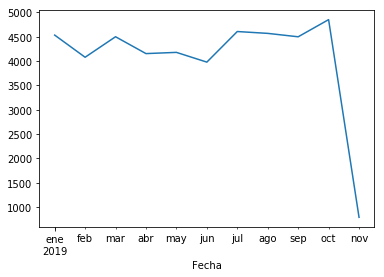

In [15]:
BD.Fecha.describe()
BD.groupby(BD.Fecha.dt.to_period('M')).Id.count().plot()

## Arreglo: números negativos segun tiempos

Dado los cálculos realizados, encuentro que hay diferencias horarias que son negativas, que no explican lo que está pasando. por lo que quiero saber cuantos n negativos existen

In [16]:
for dumm in diferenciales:
    tab_frec(BD[dumm] < pd.Timedelta(0))

,n,%
Diff_recep_Despachado,,
False,44722,100.0
Total,44722,100.0


,n,%
Diff_Despacho_Salida,,
False,44722,100.0
Total,44722,100.0


,n,%
Diff_salida_enellugar,,
False,44702,99.96
True,20,0.04
Total,44722,100.00


,n,%
Diff_z6_1,,
False,44722,100.0
Total,44722,100.0


,n,%
Diff_z6_2,,
False,44498,99.5
True,224,0.5
Total,44722,100.0


,n,%
Diff_z6_3,,
False,44196,98.82
True,526,1.18
Total,44722,100.00


Ahora excluiré aquellas entradas con valores negativos de la BD

In [17]:
for dumm in diferenciales:
    BD.loc[BD[dumm] < pd.Timedelta('0 days'),dumm] = np.nan

Ahora veré los tiempos sin contaminación

In [18]:
for dumm in diferenciales:
    tab_frec(BD[dumm] < pd.Timedelta(0))
    BD[dumm].describe()

,n,%
Diff_recep_Despachado,,
False,44722,100.0
Total,44722,100.0


count                     24821
mean     0 days 04:28:47.985496
std      0 days 03:01:25.302074
min             0 days 03:00:09
25%             0 days 03:14:04
50%             0 days 04:05:35
75%             0 days 04:32:57
max             5 days 16:52:15
Name: Diff_recep_Despachado, dtype: object

,n,%
Diff_Despacho_Salida,,
False,44722,100.0
Total,44722,100.0


count                     20039
mean     0 days 00:08:08.362243
std      0 days 00:17:57.732778
min             0 days 00:00:02
25%             0 days 00:00:51
50%             0 days 00:03:10
75%             0 days 00:08:06
max             0 days 12:09:38
Name: Diff_Despacho_Salida, dtype: object

,n,%
Diff_salida_enellugar,,
False,44722,100.0
Total,44722,100.0


count                     15888
mean     0 days 00:15:27.491943
std      0 days 00:20:08.751731
min             0 days 00:00:01
25%             0 days 00:04:56
50%             0 days 00:10:30
75%             0 days 00:18:28
max             0 days 10:51:55
Name: Diff_salida_enellugar, dtype: object

,n,%
Diff_z6_1,,
False,44722,100.0
Total,44722,100.0


count                      2583
mean     0 days 01:45:06.950445
std      0 days 01:04:36.861224
min             0 days 00:00:03
25%             0 days 01:05:10
50%             0 days 01:30:27
75%             0 days 02:08:07
max             0 days 12:34:30
Name: Diff_z6_1, dtype: object

,n,%
Diff_z6_2,,
False,44722,100.0
Total,44722,100.0


count                       365
mean     0 days 02:04:01.942465
std      0 days 02:24:51.283280
min             0 days 00:00:02
25%             0 days 00:24:15
50%             0 days 01:12:56
75%             0 days 02:39:52
max             0 days 11:47:17
Name: Diff_z6_2, dtype: object

,n,%
Diff_z6_3,,
False,44722,100.0
Total,44722,100.0


count                       938
mean     0 days 02:27:04.993603
std      0 days 02:28:08.401536
min             0 days 00:00:02
25%      0 days 00:46:15.250000
50%      0 days 01:36:35.500000
75%      0 days 03:23:33.250000
max             0 days 17:04:19
Name: Diff_z6_3, dtype: object

# Esporto la BD

In [20]:
BD.to_pickle('./BD/eSAMU.pkl')

# Datos generales

In [61]:
BD.columns

Index(['Id', 'Fecha', 'Motivo del Llamado', 'Submotivo del Llamado',
       'Prioridad', 'Estado', 'Edad', 'Género', 'Dirección', 'Sector',
       'Comuna', 'Región', 'Intervención', 'Tipo Traslado',
       'Categoría Vehículo', 'Condición Traslado', 'En Regulación',
       'En Despacho', 'En Curso', 'Atendida', 'Completado', 'Regulado',
       'Usuario que Cierra', 'Móvil Agregado', 'Móvil Despachado',
       'Móvil Salida', 'Móvil Llegada Lugar', 'Móvil en Traslado',
       'Móvil Llegada a CA', 'Móvil Recepción Paciente',
       'Móvil Camilla Retenida', 'Móvil Vuelta a Base', 'Móvil LLegada a Base',
       'Móvil Finalizado', 'Nombre Vehículo', 'Tipo Requerido',
       'Tipo Despachado', 'Km Recorrido', 'Chofer', 'Paramédico', 'Enfermero',
       'Doctor', 'Longitud', 'Latitud', 'Diff_recep_Despachado',
       'Diff_Despacho_Salida', 'Diff_salida_enellugar', 'Diff_z6_1',
       'Diff_z6_2', 'Diff_z6_3'],
      dtype='object')

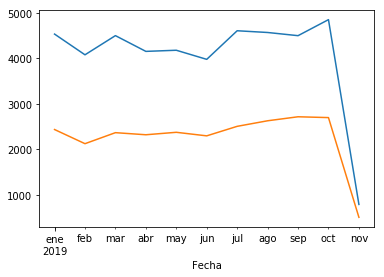

In [63]:
BD.groupby(BD.Fecha.dt.to_period('M')).Id.count().plot()
BD.groupby(BD.Fecha.dt.to_period('M'))['Nombre Vehículo'].count().plot()

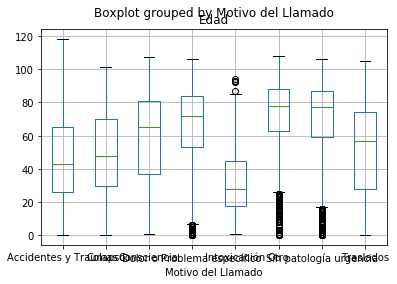

In [51]:
BD.boxplot('Edad', by = 'Motivo del Llamado')